Figure 2 Analysis: Jansen-Rit Model Parameters and E/I Balance

This script replicates Figure 2 from Momi et al. 2025:
"iTBS therapy modifies inhibitory feedback in cortical circuits differently
in responders and non-responders"

Key components:
- Figure 2A: Inhibitory feedback loop strength (I→P)
- Figure 2B: Correlation between pre-iTBS I→P weights and clinical outcomes  
- Figure 2C: E/I balance ratios across groups and timepoints

IMPORTANT: This uses pre-computed Jansen-Rit model parameters fitted to
individual subject TMS-EEG data. Raw data cannot be shared due to privacy.

In [10]:
# =============================================================================
# SETUP AND DATA DOWNLOAD
# =============================================================================

print("Figure 2: Jansen-Rit Model Parameter Analysis")
print("=" * 60)

# Install and download pre-computed model results
!apt-get -qq install -y megatools

print("Downloading pre-computed Jansen-Rit model parameters...")
print("Note: These are fitted parameters from individual subject modeling")

!megadl "https://mega.nz/file/sYlFRBQL#u1hu38gkg2e7I9iBgNe92kURiHtl-PQUojAxzGn5Dc4"  # Responder parameters
!megadl "https://mega.nz/file/lQVkSIAJ#msUr8s9I8IZUXasZg6_AgzlAndKdII7MTREhm3H7NOA"  # Non-responder parameters
!megadl "https://mega.nz/file/xZVCiRhL#RY9y32eY_xu5uYLq_IUGB3hHZo7bHYbzIbr50ZPLUOU"  # Clinical data

print("✓ Download complete!")

# @title Setup and data download


ERROR: Download failed for 'https://mega.nz/file/sYlFRBQL#u1hu38gkg2e7I9iBgNe92kURiHtl-PQUojAxzGn5Dc4': Can't rename donwloaded temporary file /content/.megatmp.sYlFRBQL to /content/model_results_non_resp.pkl (downloaded data are good!): Error moving file /content/.megatmp.sYlFRBQL: File exists

ERROR: Download failed for 'https://mega.nz/file/lQVkSIAJ#msUr8s9I8IZUXasZg6_AgzlAndKdII7MTREhm3H7NOA': Can't rename donwloaded temporary file /content/.megatmp.lQVkSIAJ to /content/model_results_resp.pkl (downloaded data are good!): Error moving file /content/.megatmp.lQVkSIAJ: File exists
Downloaded combined_df.xlsx
✓ Download complete!


In [21]:
print("\nImporting required libraries...")

import numpy as np
import os.path as op
import glob
import pandas as pd
import seaborn as sns
from scipy import stats
import pickle
from scipy.stats import pearsonr
import scipy
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks
from sklearn.metrics.pairwise import cosine_similarity
import warnings

# Configure plotting and suppress warnings
warnings.filterwarnings('ignore')
plt.style.use('default')

print("✓ Libraries imported successfully")

# @title Import


Importing required libraries...
✓ Libraries imported successfully


In [23]:
print("\nLoading Jansen-Rit model parameters...")
print("These parameters were fitted individually to each subject's TMS-EEG data")

# Load fitted model parameters for responders and non-responders
with open("/content/model_results_resp.pkl", "rb") as f:
    model_results_resp = pickle.load(f)

with open("/content/model_results_non_resp.pkl", "rb") as f:
    model_results_non_resp = pickle.load(f)

# Load clinical data
combined_df = pd.read_excel('/content/combined_df.xlsx')

# Data summary
n_responders = model_results_resp['c1'].shape[0]
n_non_responders = model_results_non_resp['c1'].shape[0]
total_subjects = n_responders + n_non_responders

print(f"✓ Data loaded successfully:")
print(f"  Total subjects: {total_subjects}")

# Parameter descriptions
param_descriptions = {
    'a': 'Excitatory time constant',
    'b': 'Inhibitory time constant',
    'c1': 'Pyramidal → Excitatory (P→E)',
    'c2': 'Excitatory → Pyramidal (E→P)',
    'c3': 'Pyramidal → Inhibitory (P→I)',
    'c4': 'Inhibitory → Pyramidal (I→P)'
}

print(f"✓ Model parameters loaded: {list(param_descriptions.keys())}")

# @title Loaded the data


Loading Jansen-Rit model parameters...
These parameters were fitted individually to each subject's TMS-EEG data
✓ Data loaded successfully:
  Total subjects: 88
✓ Model parameters loaded: ['a', 'b', 'c1', 'c2', 'c3', 'c4']


# =====================================================================
# FIGURE 2A: JANSEN-RIT PARAMETER DISTRIBUTIONS
# ======================================================================


CREATING FIGURE 2A: PARAMETER DISTRIBUTIONS
Analyzing parameter: a (Excitatory time constant)
Analyzing parameter: b (Inhibitory time constant)
Analyzing parameter: c1 (Pyramidal → Excitatory (P→E))
Analyzing parameter: c2 (Excitatory → Pyramidal (E→P))
Analyzing parameter: c3 (Pyramidal → Inhibitory (P→I))
Analyzing parameter: c4 (Inhibitory → Pyramidal (I→P))


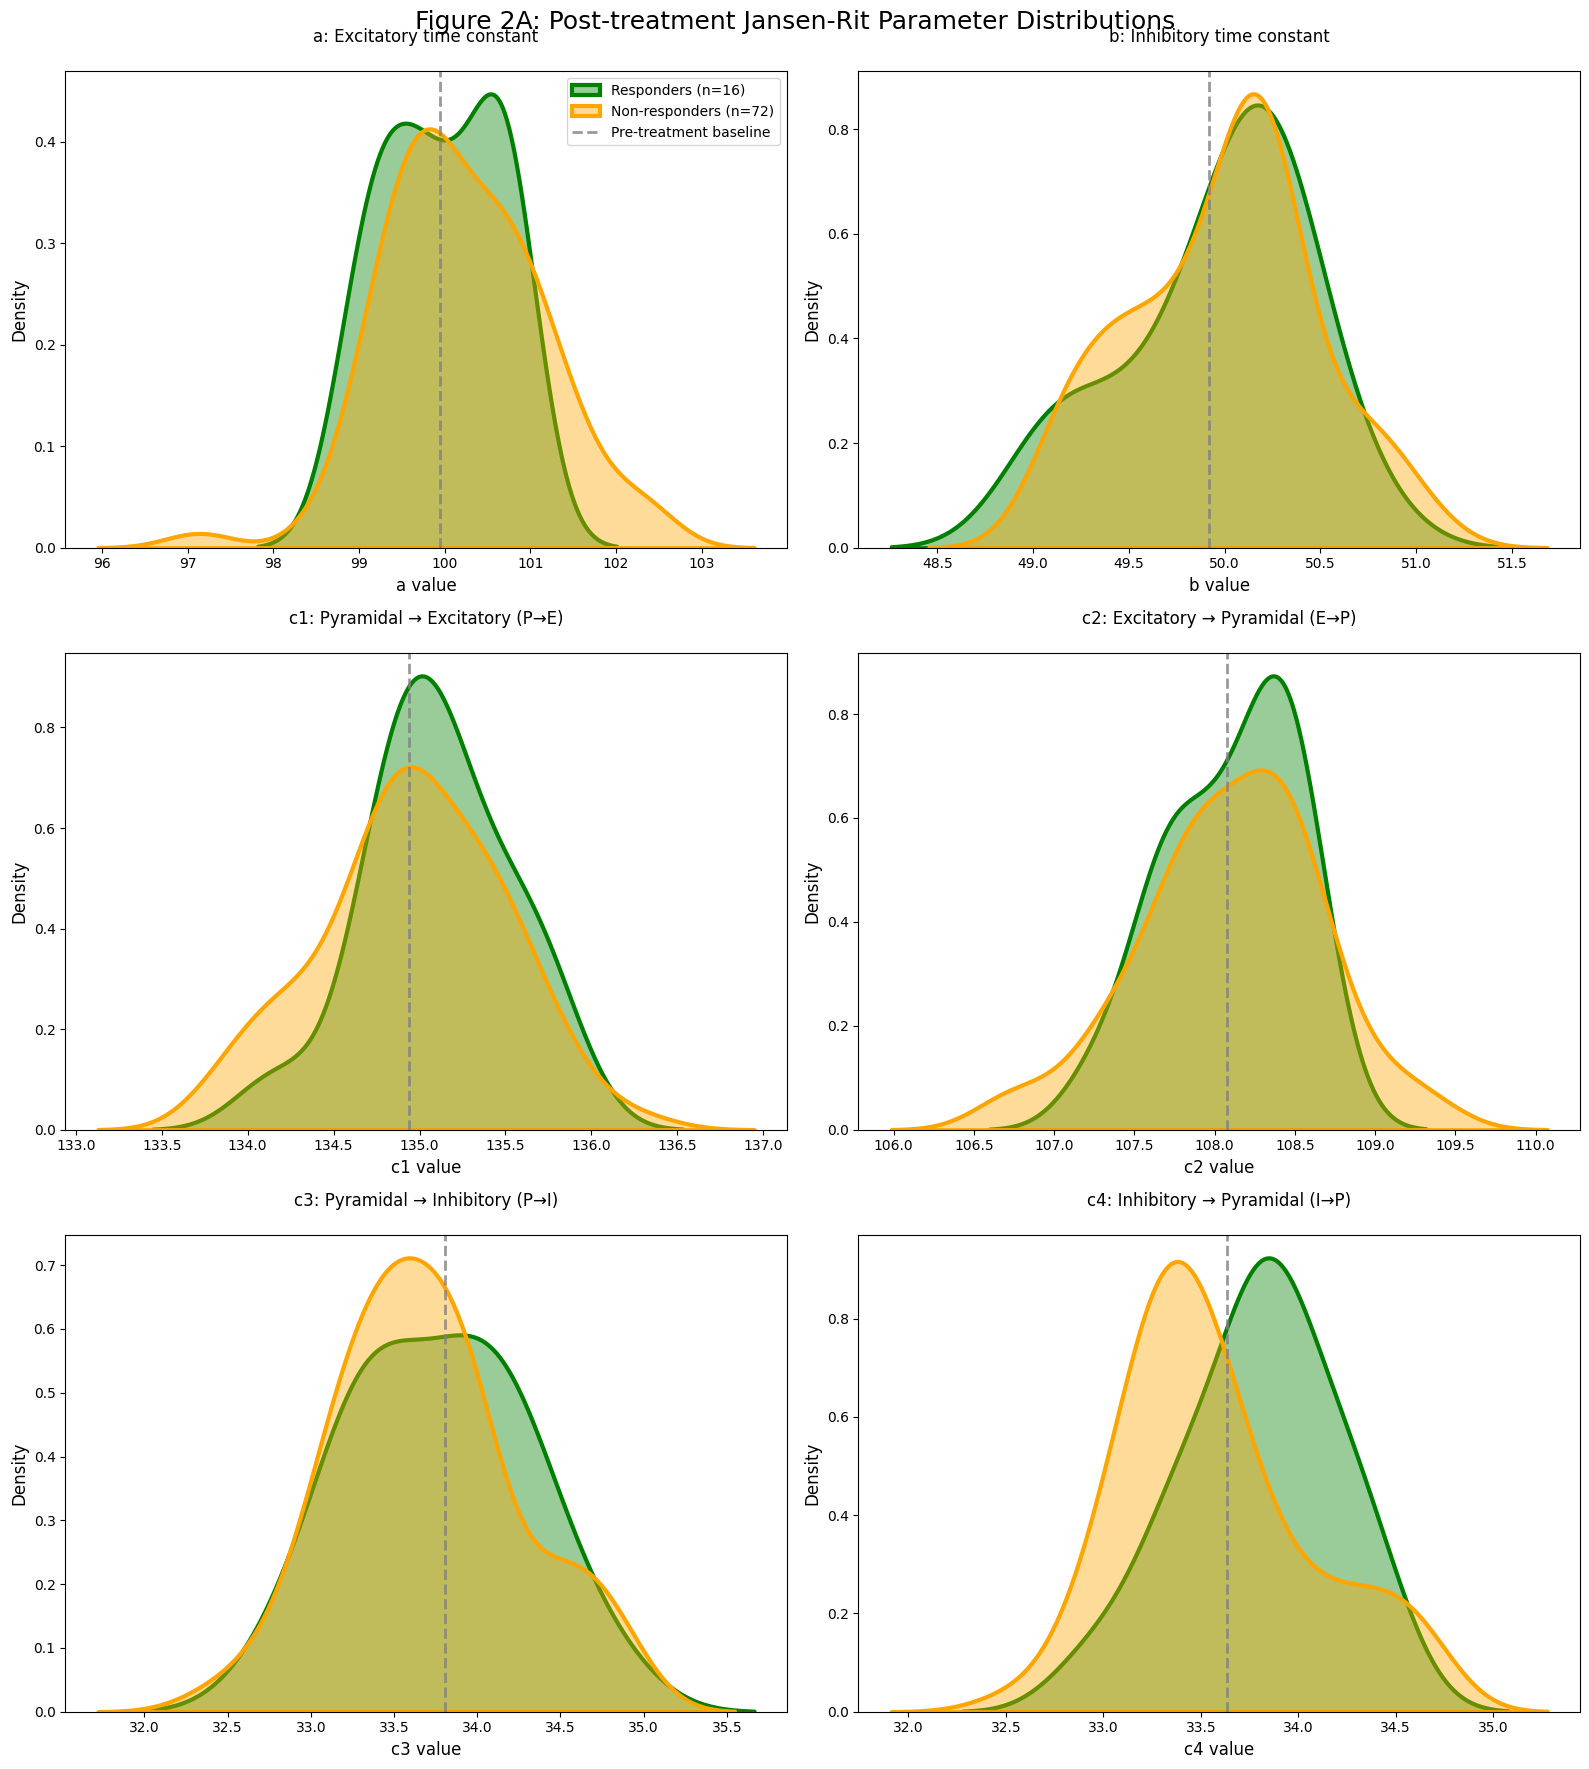

In [26]:
print("\n" + "="*60)
print("CREATING FIGURE 2A: PARAMETER DISTRIBUTIONS")
print("="*60)

# Parameters to analyze
params = ['a', 'b', 'c1', 'c2', 'c3', 'c4']

# Create enhanced subplot layout
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

# Store statistical results
stat_results = {}

for i, param in enumerate(params):
    print(f"Analyzing parameter: {param} ({param_descriptions[param]})")

    # Extract pre (T0) and post (T2) treatment data
    resp_pre = model_results_resp[param][:, 0]   # Pre-treatment responders
    resp_post = model_results_resp[param][:, 1]  # Post-treatment responders
    non_resp_pre = model_results_non_resp[param][:, 0]   # Pre-treatment non-responders
    non_resp_post = model_results_non_resp[param][:, 1]  # Post-treatment non-responders

    # Calculate pre-treatment baseline (combined groups)
    baseline_mean = (resp_pre.mean() + non_resp_pre.mean()) / 2

    # Statistical tests
    # 1. Group differences at post-treatment
    t_stat_post, p_val_post = ttest_ind(resp_post, non_resp_post)

    # 2. Within-group changes (pre vs post)
    t_stat_resp_change, p_val_resp_change = ttest_rel(resp_pre, resp_post)
    t_stat_non_resp_change, p_val_non_resp_change = ttest_rel(non_resp_pre, non_resp_post)

    # 3. Effect sizes
    effect_size_post = cohens_d(resp_post, non_resp_post)
    effect_size_resp_change = cohens_d(resp_pre, resp_post)

    # Store results
    stat_results[param] = {
        'post_treatment_t': t_stat_post,
        'post_treatment_p': p_val_post,
        'effect_size_post': effect_size_post,
        'resp_change_p': p_val_resp_change,
        'non_resp_change_p': p_val_non_resp_change
    }

    # Create distribution plot
    ax = axes[i]

    # Plot post-treatment distributions
    sns.kdeplot(resp_post, color='green', label=f'Responders (n={n_responders})',
                fill=True, alpha=0.4, linewidth=3, ax=ax)
    sns.kdeplot(non_resp_post, color='orange', label=f'Non-responders (n={n_non_responders})',
                fill=True, alpha=0.4, linewidth=3, ax=ax)

    # Add baseline reference line
    ax.axvline(baseline_mean, color='gray', linestyle='--', linewidth=2,
               label='Pre-treatment baseline', alpha=0.8)

    # Formatting
    ax.set_title(f'{param}: {param_descriptions[param]}\n')
    ax.set_xlabel(f'{param} value', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)

    # Add legend only to first subplot
    if i == 0:
        ax.legend(loc='upper right', fontsize=10)


plt.suptitle('Figure 2A: Post-treatment Jansen-Rit Parameter Distributions',
             fontsize=18, y=0.98)
plt.tight_layout()
plt.show()

# Multiple comparisons correction
p_values_post = [stat_results[param]['post_treatment_p'] for param in params]
corrected_p_values = multipletests(p_values_post, method='bonferroni')[1]




# =====================================================================
# CALCULATE E/I BALANCE - ORIGINAL METHODOLOGY
# ======================================================================

In [28]:
print("\n" + "="*60)
print("CALCULATING E/I BALANCE USING ORIGINAL PAPER METHODOLOGY")
print("="*60)
print("Computing excitation/inhibition balance ratios as described in the paper")

# Initialize arrays for E/I balance values
I_E_resp_T0 = np.zeros((model_results_resp['a'].shape[0]))    # Pre-treatment responders
I_E_resp_T2 = np.zeros((model_results_resp['a'].shape[0]))    # Post-treatment responders
I_E_non_resp_T0 = np.zeros((model_results_non_resp['a'].shape[0]))  # Pre-treatment non-responders
I_E_non_resp_T2 = np.zeros((model_results_non_resp['a'].shape[0]))  # Post-treatment non-responders

print("Applying normalization functions...")

def mean_normalization(data):
    """
    Mean-center normalization used in the original analysis
    Subtracts the mean and divides by the range
    """
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    return (data - np.mean(data, axis=0)) / (max_val - min_val)

def normalization(data):
    """
    Min-max normalization (not used in final calculation but included for completeness)
    """
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    return (data - min_val) / (max_val - min_val)

# Combine all connection strength data for proper normalization
# This ensures consistent scaling across all subjects and timepoints
print("Combining data from all subjects for consistent normalization...")

c1_combined = np.vstack([model_results_resp['c1'].copy(), model_results_non_resp['c1'].copy()])
c2_combined = np.vstack([model_results_resp['c2'].copy(), model_results_non_resp['c2'].copy()])
c3_combined = np.vstack([model_results_resp['c3'].copy(), model_results_non_resp['c3'].copy()])
c4_combined = np.vstack([model_results_resp['c4'].copy(), model_results_non_resp['c4'].copy()])

print("Applying mean-centered normalization...")

# Apply mean-centered normalization to each parameter
c1_norm = mean_normalization(c1_combined)
c2_norm = mean_normalization(c2_combined)
c3_norm = mean_normalization(c3_combined)
c4_norm = mean_normalization(c4_combined)

# Handle zero values to avoid division issues
# Replace zeros with small positive value (0.1) and take absolute values
print("Handling zero values in normalized parameters...")

c1_norm = np.abs(np.where(c1_norm == 0, 0.1, c1_norm))
c2_norm = np.abs(np.where(c2_norm == 0, 0.1, c2_norm))
c3_norm = np.abs(np.where(c3_norm == 0, 0.1, c3_norm))
c4_norm = np.abs(np.where(c4_norm == 0, 0.1, c4_norm))

print("Computing E/I balance ratios...")

# Calculate E/I balance for responders
# E/I = (Excitatory connections) / (Inhibitory connections)
# E/I = (c1 * c2) / (c3 * c4)
print("Computing E/I ratios for responders...")

for xx in range(model_results_resp['a'].shape[0]):
    # Pre-treatment (T0)
    numerator = c1_norm[xx, 0] * c2_norm[xx, 0]      # Excitatory loop strength
    denominator = c3_norm[xx, 0] * c4_norm[xx, 0]    # Inhibitory loop strength
    I_E_resp_T0[xx] = numerator / denominator

    # Post-treatment (T2)
    numerator = c1_norm[xx, 1] * c2_norm[xx, 1]      # Excitatory loop strength
    denominator = c3_norm[xx, 1] * c4_norm[xx, 1]    # Inhibitory loop strength
    I_E_resp_T2[xx] = numerator / denominator

# Calculate E/I balance for non-responders
print("Computing E/I ratios for non-responders...")

for xx in range(model_results_non_resp['a'].shape[0]):
    # Correct indexing: non-responder data starts after responder data
    i = xx + model_results_resp['a'].shape[0]

    # Pre-treatment (T0)
    numerator = c1_norm[i, 0] * c2_norm[i, 0]        # Excitatory loop strength
    denominator = c3_norm[i, 0] * c4_norm[i, 0]      # Inhibitory loop strength
    I_E_non_resp_T0[xx] = numerator / denominator

    # Post-treatment (T2)
    numerator = c1_norm[i, 1] * c2_norm[i, 1]        # Excitatory loop strength
    denominator = c3_norm[i, 1] * c4_norm[i, 1]      # Inhibitory loop strength
    I_E_non_resp_T2[xx] = numerator / denominator

print("✓ E/I balance calculations completed")



CALCULATING E/I BALANCE USING ORIGINAL PAPER METHODOLOGY
Computing excitation/inhibition balance ratios as described in the paper
Applying normalization functions...
Combining data from all subjects for consistent normalization...
Applying mean-centered normalization...
Handling zero values in normalized parameters...
Computing E/I balance ratios...
Computing E/I ratios for responders...
Computing E/I ratios for non-responders...
✓ E/I balance calculations completed


# =====================================================================
# FIGURE 2C: E/I BALANCE BAR PLOT
# ======================================================================


CREATING FIGURE 2C: E/I BALANCE VISUALIZATION
Showing E/I balance ratios across groups and timepoints


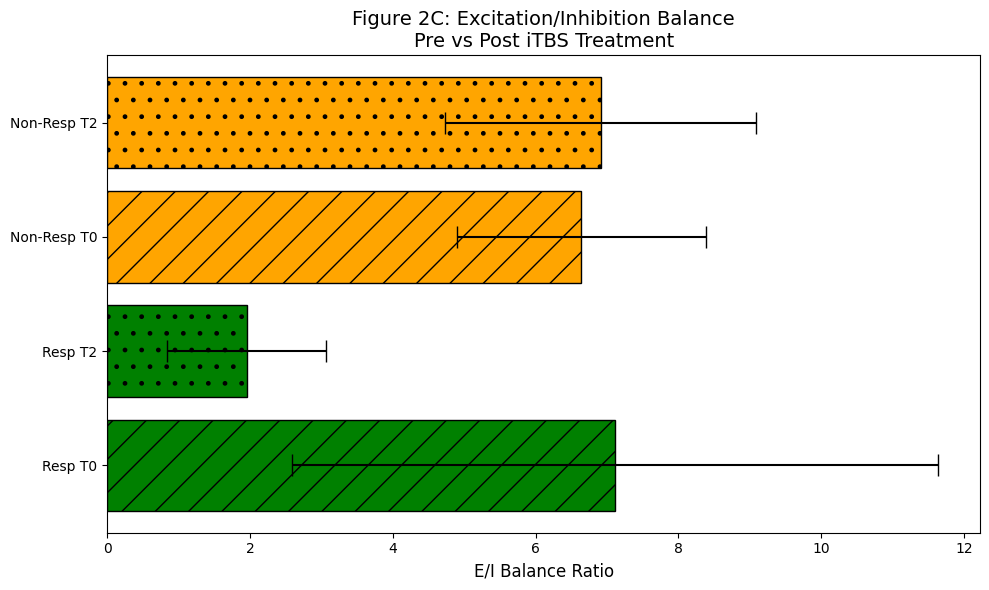

✓ Figure 2C completed
Key findings:
  Responders show decrease in E/I balance post-treatment
  Non-responders show increase in E/I balance post-treatment


In [30]:
print("\n" + "="*60)
print("CREATING FIGURE 2C: E/I BALANCE VISUALIZATION")
print("="*60)
print("Showing E/I balance ratios across groups and timepoints")

# Calculate means and standard errors for visualization
means = [
    np.mean(I_E_resp_T0),      # Responders pre-treatment
    np.mean(I_E_resp_T2),      # Responders post-treatment
    np.mean(I_E_non_resp_T0),  # Non-responders pre-treatment
    np.mean(I_E_non_resp_T2)   # Non-responders post-treatment
]

# Calculate standard error of the mean (SEM) for error bars
std_devs = [
    np.std(I_E_resp_T0) / (np.sqrt(I_E_resp_T0.shape[0])),
    np.std(I_E_resp_T2) / (np.sqrt(I_E_resp_T0.shape[0])),
    np.std(I_E_non_resp_T0) / (np.sqrt(I_E_non_resp_T0.shape[0])),
    np.std(I_E_non_resp_T2) / (np.sqrt(I_E_non_resp_T0.shape[0]))
]

# Create enhanced horizontal bar plot
labels = ['Resp T0', 'Resp T2', 'Non-Resp T0', 'Non-Resp T2']
x_pos = np.arange(len(labels))

plt.figure(figsize=(10, 6))

# Create horizontal bar plot with error bars
bars = plt.barh(x_pos, means, xerr=std_devs, capsize=8,
                color=['green', 'green', 'orange', 'orange'],
                edgecolor='black')

# Apply hatch patterns to distinguish pre vs post treatment
# Solid bars = pre-treatment, hatched bars = post-treatment
hatch_patterns = ['/', '.', '/', '.']
for bar, hatch in zip(bars, hatch_patterns):
    bar.set_hatch(hatch)

# Format the plot
plt.yticks(x_pos, labels)
plt.xlabel('E/I Balance Ratio', fontsize=12)
plt.title('Figure 2C: Excitation/Inhibition Balance\n'
          'Pre vs Post iTBS Treatment', fontsize=14)


plt.tight_layout()
plt.show()

print("✓ Figure 2C completed")
print(f"Key findings:")
print(f"  Responders show {'increase' if means[1] > means[0] else 'decrease'} in E/I balance post-treatment")
print(f"  Non-responders show {'increase' if means[3] > means[2] else 'decrease'} in E/I balance post-treatment")



# =====================================================================
# FIGURE 2B: CLINICAL CORRELATION ANALYSIS
# ======================================================================


CREATING FIGURE 2B: CLINICAL CORRELATION
Analyzing correlation between pre-treatment parameters and clinical outcomes
Correlation analysis: c4_T0 vs hamd_t30
Focus: Pre-treatment inhibitory strength predicting treatment outcome
Outlier detection: Enabled
  Threshold: 2 standard deviations
Initial data points: 88
Applying outlier detection...
Data points after outlier removal: 82
Responder data points for correlation: 27
Correlation results (Responders only):
  Pearson r = -0.558
  p-value = 0.0025


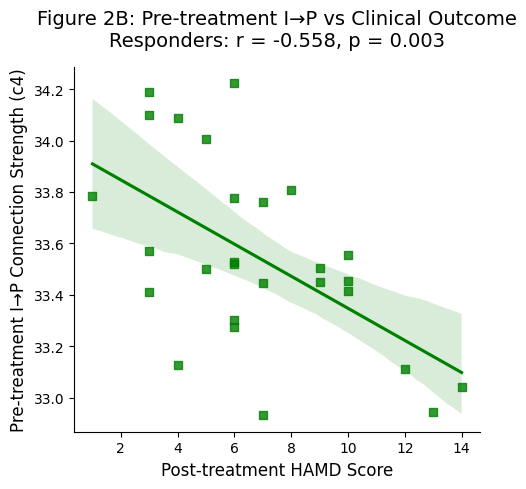

✓ Figure 2B completed


In [36]:
print("\n" + "="*60)
print("CREATING FIGURE 2B: CLINICAL CORRELATION")
print("="*60)
print("Analyzing correlation between pre-treatment parameters and clinical outcomes")

# Define the key parameter and clinical variable
# c4 = Inhibitory → Pyramidal connection strength (key finding from paper)
param_to_plot = 'c4_T0'  # Pre-treatment c4 parameter
clinical_variable = 'hamd_t30'  # Post-treatment HAMD score

print(f"Correlation analysis: {param_to_plot} vs {clinical_variable}")
print("Focus: Pre-treatment inhibitory strength predicting treatment outcome")

# Configure outlier detection
exclude_outliers = True
out_thr = 2  # Number of standard deviations for outlier exclusion

print(f"Outlier detection: {'Enabled' if exclude_outliers else 'Disabled'}")
if exclude_outliers:
    print(f"  Threshold: {out_thr} standard deviations")

# Create correlation analysis dataframe
df2plot = pd.DataFrame(np.vstack((combined_df[clinical_variable],
                                  np.array(combined_df[param_to_plot]),
                                  (combined_df['Response'] == 'RESPONDER').astype(int))).T,
                       columns=['var2use', param_to_plot, 'Response'])

print(f"Initial data points: {len(df2plot)}")

# Apply outlier detection if enabled
if exclude_outliers:
    print("Applying outlier detection...")

    # Remove outliers for the parameter
    mean_param = df2plot[param_to_plot].mean()
    std_param = df2plot[param_to_plot].std()
    df2plot = df2plot[(np.abs(df2plot[param_to_plot] - mean_param) <= out_thr * std_param)]

    # Remove outliers for the clinical variable
    mean_clinical = df2plot['var2use'].mean()
    std_clinical = df2plot['var2use'].std()
    df2plot = df2plot[(np.abs(df2plot['var2use'] - mean_clinical) <= out_thr * std_clinical)]

    print(f"Data points after outlier removal: {len(df2plot)}")

# Focus analysis on responders only (as highlighted in the paper)
df2plot_responders = df2plot[df2plot['Response'] == 1]

print(f"Responder data points for correlation: {len(df2plot_responders)}")

# Create the scatter plot for responders only
scatter = sns.lmplot(
    x='var2use',
    y=param_to_plot,
    data=df2plot_responders,
    markers=['s'],
    scatter_kws={'color': 'green'},  # Color for the scatter points
    line_kws={'color': 'green'}  # Color for the regression line
)

# Calculate correlation statistics for responders
r_resp, p_resp = scipy.stats.pearsonr(
    df2plot_responders['var2use'],
    df2plot_responders[param_to_plot]
)

print(f"Correlation results (Responders only):")
print(f"  Pearson r = {r_resp:.3f}")
print(f"  p-value = {p_resp:.4f}")

# Format the plot
ax = plt.gca()
ax.set_title(f'Figure 2B: Pre-treatment I→P vs Clinical Outcome\n'
             f'Responders: r = {r_resp:.3f}, p = {p_resp:.3f}',
             fontsize=14, pad=15)
ax.set_xlabel('Post-treatment HAMD Score', fontsize=12)
ax.set_ylabel('Pre-treatment I→P Connection Strength (c4)', fontsize=12)

plt.tight_layout()
plt.show()

print("✓ Figure 2B completed")


Loading Jansen-Rit model parameters...
These parameters were fitted individually to each subject's TMS-EEG data
✓ Data loaded successfully:
  Total subjects: 88
✓ Model parameters loaded: ['a', 'b', 'c1', 'c2', 'c3', 'c4']
